# Numerical Methods for Regression & Optimization (Python)

## Overview
This notebook demonstrates practical implementations of core numerical methods used in data science and applied analytics:
- **Least squares via QR factorization** (including a distributed/partitioned-data workflow)
- **Binary classification with logistic regression** optimized with **gradient-based methods**
- **Non-linear least squares** estimated with **BFGS** (quasi-Newton) and model comparison using **RSS**

The focus is on *transparent implementation*, *numerical stability*, and *reproducible results*—in a format ready for a technical portfolio.

## Contents
1. **QR-based Least Squares (partitioned data)**
2. **Logistic Regression Optimization**
3. **Non-linear Model Estimation with BFGS**


# 1) QR-based Least Squares (Partitioned Data)

### Context

In many real-world pipelines, the full design matrix cannot be held in memory on a single machine (or it is operationally stored in partitions). We model this by splitting the data across \(m\) workers:

\[
\mathbf{y} =
\begin{bmatrix}
\mathbf{y}_1 \\ \mathbf{y}_2 \\ \vdots \\ \mathbf{y}_m
\end{bmatrix},
\qquad
\mathbf{X} =
\begin{bmatrix}
\mathbf{X}_1 \\ \mathbf{X}_2 \\ \vdots \\ \mathbf{X}_m
\end{bmatrix},
\]

where \((\mathbf{X}_j,\mathbf{y}_j)\) is the partition stored on worker \(j\).

Rather than forming \(\mathbf{X}^\top\mathbf{X}\) explicitly (which can be ill-conditioned), we use a QR factorization to obtain a numerically stable least-squares solution. In the partitioned setting, each worker contributes local quantities that can be aggregated centrally to recover the global estimate without moving the full dataset.


### Implementation notes

We apply the QR-based least-squares workflow to two lightweight case studies to highlight numerical stability, interpretability, and a clean engineering pattern for regression on large or partitioned datasets:

1. **`cars` (R dataset)**  
   Build the design matrix \(X = (1,\ \text{speed})\) and response \(y = \text{dist}\). This provides a simple, well-known baseline where the fitted parameters are easy to sanity-check.

2. **`diamonds` (ggplot2 dataset)**  
   Fit a one-predictor linear model with an intercept (one explanatory variable) to illustrate how the same QR pipeline behaves on a larger, noisier dataset and how scaling affects conditioning.

The “partitioned data” variant mirrors production settings where data arrives in batches (e.g., daily extracts) and the model must be updated or recomputed without loading everything into memory at once.


In [39]:
import numpy as np
import pandas as pd
import time
from plotnine.data import diamonds
import seaborn as sns

In [40]:
# ---------------------------------------------------------
#  QR Decomposition using Gram–Schmidt
# ---------------------------------------------------------
def desc_qr_gs(x):
    n, p = x.shape
    u = np.zeros((n, p))
    q = np.zeros((n, p))

    for j in range(p):
        u[:, j] = x[:, j]
        if j > 0:
            for k in range(j):
                u[:, j] -= (np.sum(u[:, k] * x[:, j]) / np.sum(u[:, k] ** 2)) * u[:, k]
        q[:, j] = u[:, j] / np.sqrt(np.sum(u[:, j] ** 2))

    r = q.T @ x
    return q, r

In [41]:
import pandas as pd

cars = pd.read_csv("cars.csv", sep=",")
diamonds = pd.read_csv("diamonds.csv", sep=",")

In [42]:
print(cars.shape)

(50, 2)


In [45]:
print(diamonds.shape)

(53940, 10)


In [7]:
cars.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


In [8]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
y = diamonds["price"].values
X = np.column_stack([np.ones(len(diamonds)), diamonds["carat"].values]) # design matrix

In [ ]:
#y = cars["dist"].values
#X = np.column_stack([np.ones(len(cars)), cars["speed"].values])

In [47]:
# ---------------------------------------------------------
#  Partitions into 5 blocks of size 10
# ---------------------------------------------------------
m = 5
Xlist = []
ylist = []

for j in range(m):
    Xlist.append(X[j*10 : j*10 + 10, :])
    ylist.append(y[j*10 : j*10 + 10])

In [ ]:
# ---------------------------------------------------------
#  Map–Reduce algorithm (a standard approach for large-scale data)
# ---------------------------------------------------------
def map_reduce_alg(particiones_X, particiones_y):
    num_particiones = len(particiones_X)
    num_predictores = particiones_X[0].shape[1]

    lista_Q = []
    matriz_R_completa = np.zeros((0, num_predictores))

    # Step 1: QR on each partition
    for i in range(num_particiones):
        Q_i, R_i = desc_qr_gs(particiones_X[i])
        lista_Q.append(Q_i)
        matriz_R_completa = np.vstack([matriz_R_completa, R_i])

    # Paso 2: QR global
    Q_global, R_global = desc_qr_gs(matriz_R_completa)

    suma_V = np.zeros(num_predictores)

    # Paso 3: sumar V_j = Q_j^(3)ᵀ y_j
    for i in range(num_particiones):
        Q_part_2 = Q_global[i*num_predictores : (i+1)*num_predictores, :]
        suma_V += (lista_Q[i] @ Q_part_2).T @ particiones_y[i]

    beta = np.linalg.solve(R_global, suma_V)
    return beta

In [49]:
B = 100
t1_start = time.time()
for _ in range(B):
    Q, R = desc_qr_gs(X)
    beta_gorro = np.linalg.solve(R, Q.T @ y)
t1 = (time.time() - t1_start) / B


In [50]:
t2_start = time.time()
for _ in range(B):
    beta_map_reduce = map_reduce_alg(Xlist, ylist)
t2 = (time.time() - t2_start) / B

In [ ]:
# Case: diamonds (54k observations)
print(f"Average (Direct)   : {100*t1:.2f} ms")
print(f"Average (Map–Reduce): {100*t2:.2f} ms")

Promedio Directo   : 0.15 ms
Promedio Map-Reduce: 0.05 ms


In [ ]:
# Case: cars (50 observations)
print(f"Average (Direct)   : {100*t1:.2f} ms")
print(f"Average (Map–Reduce): {100*t2:.2f} ms")

Promedio Directo   : 0.01 ms
Promedio Map-Reduce: 0.06 ms


# 2) Logistic Regression Optimization

Let $y_i \in \{0,1\}$ for $i=1,\dots,n$ with systematic component

$$
\eta_i = x_i^\top\beta, \qquad p_i = \Pr(y_i=1\mid x_i)=\sigma(\eta_i)=\frac{1}{1+e^{-\eta_i}},
\qquad X\in\mathbb{R}^{n\times p}.
$$

The log-likelihood is

$$
\ell(\beta)=\sum_{i=1}^n \Big[ y_i \log p_i + (1-y_i)\log(1-p_i) \Big].
$$

The negative log-likelihood can be used as a loss function:

$$
f(\beta) = -\frac{1}{n}\ell(\beta).
$$

- **Gradient**:

$$
\nabla f(\beta)=\tfrac{1}{n}X^\top(\sigma(X\beta)-y).
$$

Gradient descent iterates

$$
\beta^{(m+1)} = \beta^{(m)} - \eta \,\nabla f(\beta^{(m)}),
$$
where $\eta>0$ is the learning rate.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
df = sm.datasets.get_rdataset("mtcars").data.copy()

# Standardization
df["mpg_z"] = (df["mpg"] - df["mpg"].mean()) / df["mpg"].std()
df["hp_z"]  = (df["hp"]  - df["hp"].mean()) / df["hp"].std()
df["y"]     = df["vs"]

# design matrix
X = np.column_stack([np.ones(len(df)), df["mpg_z"], df["hp_z"]])
y = df["y"].values
n = len(y)

In [ ]:
# -------------------------------------------------------------------
# Helper functions
# -------------------------------------------------------------------

def sigm(u):
    return 1 / (1 + np.exp(-u))

def logloss(beta, X, y):
    xb = X @ beta
    return np.mean(-y * xb + np.log1p(np.exp(xb))) # Note: log1p = log(1+x) improves numerical stability when x is small

def grad_logloss(beta, X, y):
    return (X.T @ (sigm(X @ beta) - y)) / len(y)

In [ ]:
# -------------------------------------------------------------------
# Fit via glm()
# -------------------------------------------------------------------

model = sm.GLM(df["y"], sm.add_constant(df[["mpg_z","hp_z"]]),
               family=sm.families.Binomial())
fit_glm = model.fit()

coef_glm = fit_glm.params.values
loss_glm = logloss(coef_glm, X, y)

In [5]:
# -------------------------------------------------------------------
# Gradiente descendente
# -------------------------------------------------------------------

def gd_fit(beta0, X, y, eta=1e-2, tol=1e-6, maxit=50000):
    beta = beta0.copy()

    hist = {
        "it": [0],
        "f":  [logloss(beta, X, y)],
        "b0": [beta[0]],
        "b1": [beta[1]],
        "b2": [beta[2]]
    }

    for it in range(1, maxit+1):
        g = grad_logloss(beta, X, y)

        if np.linalg.norm(g) < tol:
            break

        beta -= eta * g

        if it % 100 == 0:
            hist["it"].append(it)
            hist["f"].append(logloss(beta, X, y))
            hist["b0"].append(beta[0])
            hist["b1"].append(beta[1])
            hist["b2"].append(beta[2])

    return {"beta": beta, "iters": it, "hist": pd.DataFrame(hist)}

In [ ]:
np.random.seed(2025)
fit_gd = gd_fit(np.zeros(X.shape[1]), X, y)

coef_gd = fit_gd["beta"]
iters_gd = fit_gd["iters"]
hist    = fit_gd["hist"]

In [7]:
iterations_df = pd.DataFrame({
    "Method": ["GD batch"],
    "Iterations": [iters_gd]
})

coefficients_df = pd.DataFrame({
    "GD":  np.round(coef_gd, 4)
}, index=["(Intercept)", "mpg_z", "hp_z"])

print(f'{iterations_df}\n')
print(coefficients_df)

     Método  Iteraciones
0  GD batch        50000

                 GD
(Intercept) -1.6538
mpg_z       -0.1265
hp_z        -4.7095


In [8]:
print(f'Coefficients from statsmodels GLM: {coef_glm}')

Coeficientes con la función GLM: [-1.75965268 -0.2040335  -4.95952704]


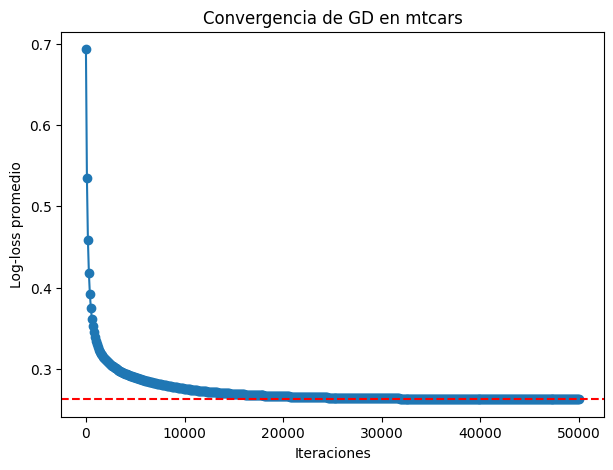

In [9]:
plt.figure(figsize=(7,5))
plt.plot(hist["it"], hist["f"], "-o")
plt.axhline(y=loss_glm, linestyle="--", color="red")
plt.xlabel("Iterations")
plt.ylabel("Average log-loss")
plt.title("GD convergence on mtcars")
plt.show()

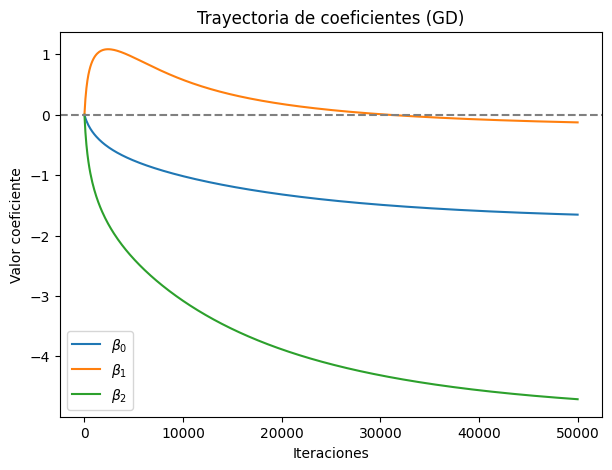

In [10]:
plt.figure(figsize=(7,5))
plt.plot(hist["it"], hist["b0"], label=r"$\beta_0$")
plt.plot(hist["it"], hist["b1"], label=r"$\beta_1$")
plt.plot(hist["it"], hist["b2"], label=r"$\beta_2$")
plt.axhline(0, linestyle="--", color="gray")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Coefficient value")
plt.title("Coefficient path (GD)")
plt.show()

In [12]:
b0_fix = coef_glm[0]

b1_seq = np.linspace(-1, 1, 60)
b2_seq = np.linspace(-6, 0, 60)

zz = np.array([
    [logloss(np.array([b0_fix, b1, b2]), X, y) for b2 in b2_seq]
    for b1 in b1_seq
])

fig = go.Figure()

fig.add_surface(
    x=b1_seq, y=b2_seq, z=zz,
    colorscale="Viridis", opacity=0.8
)

fig.add_scatter3d(
    x=hist["b1"], y=hist["b2"], z=hist["f"],
    mode="lines+markers",
    line=dict(color="red", width=5),
    marker=dict(size=4, color="red")
)

fig.update_layout(
    scene=dict(
        xaxis_title="b1 (mpg_z)",
        yaxis_title="b2 (hp_z)",
        zaxis_title="Loss"
    ),
    title="Loss surface and GD trajectory"
)

fig.show()

### Stochastic Gradient Descent (SGD)

Beyond full-batch gradient descent, we also consider a stochastic variant where the gradient is computed from a single observation (or a small mini-batch) at each step. This reduces the per-iteration cost and often improves scalability, at the expense of higher gradient noise.

In this section, SGD is used as an optimization lens: we track objective behavior, step-size sensitivity, and practical convergence characteristics when training logistic regression.


![](sgd1.webp)



![](ex1.png)




![](sgd2.jpg)


# 3) Non-linear Least Squares with BFGS

### Parameter estimation under fixed \(\gamma\)

To study identifiability and model adequacy in a controlled setting, we fix \(\gamma = 1\) and estimate \(\alpha\) and \(\beta\) by minimizing the residual sum of squares (RSS).

We report the fitted parameters, visualize the fitted curve against the observations, and inspect residuals to evaluate whether a linear specification is consistent with the data-generating behavior.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

In [20]:
data = pd.read_csv("F5_2.txt", delim_whitespace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_13776\3280562796.py:1: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [23]:
X = sm.add_constant(data["realdpi"])
Y = data["realcons"]

reg = sm.OLS(Y, X).fit()
theta0 = np.array([reg.params[0], reg.params[1], 1.0])


C:\Users\andre\AppData\Local\Temp\ipykernel_13776\2894232734.py:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



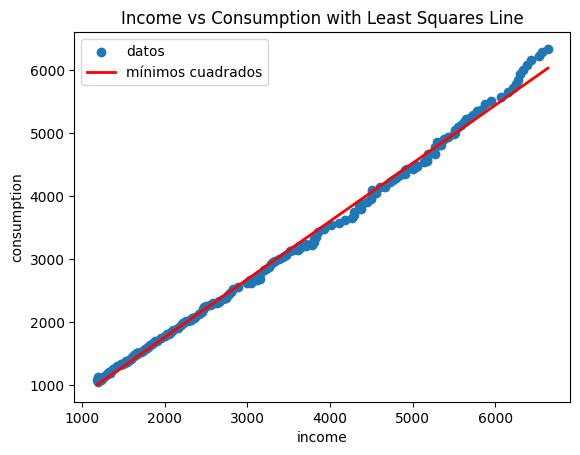

In [31]:
# Scatter plot
plt.scatter(data["realdpi"], data["realcons"], label="data")

# Linear model line
plt.plot(data["realdpi"], reg.fittedvalues, color="red", linewidth=2, label="least squares")

plt.xlabel("income")
plt.ylabel("consumption")
plt.title("Income vs Consumption with Least Squares Line")
plt.legend()
plt.show()

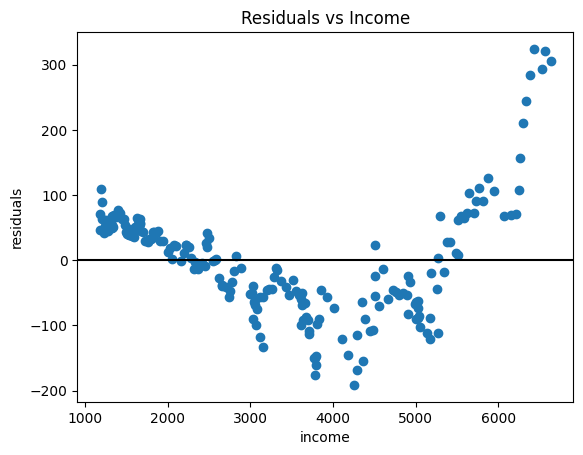

In [32]:
plt.scatter(data["realdpi"], reg.resid)
plt.axhline(0, color="black")

plt.xlabel("income")
plt.ylabel("residuals")
plt.title("Residuals vs Income")
plt.show()

## Estimation with BFGS (quasi-Newton)

We estimate the parameters of the non-linear model via **non-linear least squares**, using **BFGS** (a quasi-Newton method) as implemented in `scipy.optimize.minimize`.

The objective is the **residual sum of squares (RSS)**. We report the optimized parameters, visualize the fitted model against the observations, and examine residual structure to validate whether the non-linear specification captures the dominant trend.


In [ ]:
# ---------------------------------------------------------
# RSS (Residual Sum of Squares): sum of squared differences between observed values
# and the model predictions.
# theta = (alpha, beta, gamma)
# ---------------------------------------------------------
def RSS(theta, y, z):
    alpha, beta, gamma = theta
    yhat = alpha + beta * (z ** gamma)
    return np.sum((y - yhat) ** 2)


In [25]:

# ---------------------------------------------------------
# Optimization with BFGS
# ---------------------------------------------------------
result = minimize(
    RSS,
    theta0,
    args=(data["realcons"].values, data["realdpi"].values),
    method="BFGS",
    options={"disp": True, "maxiter": 1000} 
)

theta = result.x

         Current function value: 504403.218621
         Iterations: 84
         Function evaluations: 572
         Gradient evaluations: 140


c:\Users\andre\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.



In [26]:

print("Estimated parameters (alpha, beta, gamma):")
print(theta)

Parámetros estimados (alpha, beta, gamma):
[4.58817210e+02 1.00841313e-01 1.24483950e+00]


### Interpretation
The estimated parameters indicate a positive association between income and consumption. 
In particular, the exponent parameter suggests a nonlinear relationship: consumption increases more than proportionally with income when the exponent is greater than 1, and less than proportionally when it is below 1. 
This flexible power-law specification can capture curvature that a simple linear model may miss, and it is especially useful when marginal propensity to consume changes across the income range.


In [27]:
# ---------------------------------------------------------
# Calcular predicciones no lineales
# ---------------------------------------------------------
yhat = theta[0] + theta[1] * (data["realdpi"].values ** theta[2])

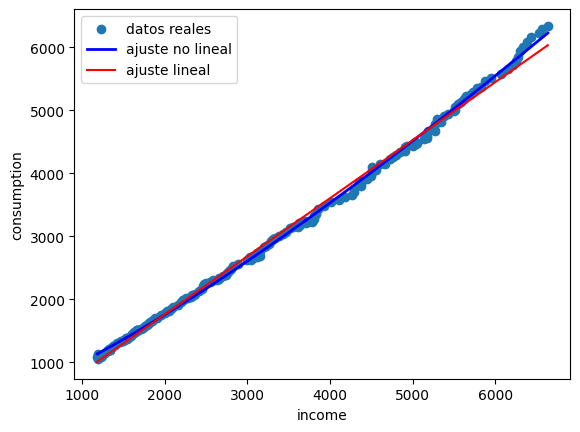

In [28]:

plt.scatter(data["realdpi"], data["realcons"], label="observed data")
plt.plot(data["realdpi"], yhat, color="blue", linewidth=2, label="nonlinear fit")
plt.plot(data["realdpi"], reg.fittedvalues, color="red", label="linear fit")

plt.xlabel("income")
plt.ylabel("consumption")
plt.legend()
plt.show()

In [29]:

# ---------------------------------------------------------
# RSS del modelo lineal (antes)
# ---------------------------------------------------------
RSS_lineal = np.sum(reg.resid ** 2)
print("RSS lineal (gamma = 1):", RSS_lineal)


RSS lineal (gamma = 1): 1536321.880788025


In [30]:

# ---------------------------------------------------------
# RSS del modelo NO lineal (ahora)
# ---------------------------------------------------------
RSS_nonlineal = np.sum((data["realcons"].values - yhat) ** 2)
print("RSS no lineal:", RSS_nonlineal)

RSS no lineal: 504403.2186210114


### Model comparison (RSS)

We compare the linear and non-linear specifications using **RSS** on the same observations. A materially lower RSS for the non-linear model (here, a reduction on the order of ~65% relative to the linear baseline) indicates that the additional flexibility better explains the observed relationship under this metric.

Importantly, RSS alone is not a full model-selection criterion; it is interpreted here as an empirical fit comparison within this controlled experiment.
